## Final Project Proposal

By Evan Richardson

I've enjoyed chess for a long time and have wanted to dive into machine learning in the deep end right away.  For this project, I would like to analyze the position of the pieces for the most likely outcome given equal skilled players.  In order to gather the data for this project, I will initially load PGN(portable game notation for games) data gathered from https://www.ficsgames.org/download.html for games above 2000 rating.  From this data, I created a a data loader to interpret each move and create a snapshot of the game after each move, and hopefully from this project I can create a model that will predict who will likely win from the given state of the game.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Hypothesis

From this project, I hope to find which positions are the best to be in for chess and the probability of wins given these positions.  This can be applied to any chess systems, and in general feeds into my curiousity about the game.  I'm not aiming to create a predictive move model, just to find who is in the advantage in certain situations.

### Dataset

All the data I have gathered is from https://www.ficsgames.org/download.html, which provides data for a lot of games, over 7000 in January 2018 alone.  The data provided however is not a csv, but PGN, so I wrote an interpreter to translate the moves in the file to actual board states after every move, and from these game states, I wrote the result for testing the data, the number of each piece for each player and their total number of pieces, along with the piece and the color of the piece for each square on the board, flattening the board object.

In [2]:
df = pd.read_csv('../data/201801_games.csv')

In [3]:
df.head()

,Result,WhitePawns,BlackPawns,WhiteRooks,BlackRooks,WhiteBishops,BlackBishops,WhiteKnights,BlackKnights,WhiteQueen,...,d8_color,d8_piece,e8_color,e8_piece,f8_color,f8_piece,g8_color,g8_piece,h8_color,h8_piece
0,1.0,8,8,2,2,2,2,2,2,1,...,2,Q,2,K,2,B,2,N,2,R
1,1.0,8,8,2,2,2,2,2,2,1,...,2,Q,2,K,2,B,2,N,2,R
2,1.0,8,8,2,2,2,2,2,2,1,...,2,Q,2,K,2,B,2,N,2,R
3,1.0,8,8,2,2,2,2,2,2,1,...,2,Q,2,K,2,B,2,N,2,R
4,1.0,8,8,2,2,2,2,2,2,1,...,2,Q,2,K,2,B,2,N,2,R


In [4]:
df.shape

(52500, 143)

The color and piece columns are coded, with color having values of 0 = Empty, 1 = White, and 2 = Black.

Pieces are '' = Empty, P = Pawn, R = Rook, B = Bishop, N = Knight, Q = Queen, and K = King.

The piece counts are continuous based on the number of pieces on the board for each side.

Result also has the possibility to be 1 = White win, 0.5 = Draw, and 0 = Black win.  This leads to interesting possibilities for approaches as well, since I could likely use classification or regression depending on the approach.

Classification can predict the winner, but regression has the advantage of being able to predict who is likely winning the game in the current board state.

### Data Preprocessing

Since I created this dataset, all of the columns have value and don't need to be removed.  There are empty values for the squares where there isn't a piece, but these should still be empty, and when I convert them to one-hot encodings, the dummy columns will all be 0's.

For each square, the color and piece are categorical, so I will create dummy variables to encode the column.

In [6]:
numerical_columns = list(df.columns[1:-128])
print(numerical_columns)

categorical_columns = list(df.columns[-128:])
print(categorical_columns)

['WhitePawns', 'BlackPawns', 'WhiteRooks', 'BlackRooks', 'WhiteBishops', 'BlackBishops', 'WhiteKnights', 'BlackKnights', 'WhiteQueen', 'BlackQueen', 'WhiteKing', 'BlackKing', 'WhiteTotal', 'BlackTotal']
['a1_color', 'a1_piece', 'b1_color', 'b1_piece', 'c1_color', 'c1_piece', 'd1_color', 'd1_piece', 'e1_color', 'e1_piece', 'f1_color', 'f1_piece', 'g1_color', 'g1_piece', 'h1_color', 'h1_piece', 'a2_color', 'a2_piece', 'b2_color', 'b2_piece', 'c2_color', 'c2_piece', 'd2_color', 'd2_piece', 'e2_color', 'e2_piece', 'f2_color', 'f2_piece', 'g2_color', 'g2_piece', 'h2_color', 'h2_piece', 'a3_color', 'a3_piece', 'b3_color', 'b3_piece', 'c3_color', 'c3_piece', 'd3_color', 'd3_piece', 'e3_color', 'e3_piece', 'f3_color', 'f3_piece', 'g3_color', 'g3_piece', 'h3_color', 'h3_piece', 'a4_color', 'a4_piece', 'b4_color', 'b4_piece', 'c4_color', 'c4_piece', 'd4_color', 'd4_piece', 'e4_color', 'e4_piece', 'f4_color', 'f4_piece', 'g4_color', 'g4_piece', 'h4_color', 'h4_piece', 'a5_color', 'a5_piece', 'b5_

I don't want to create a dummy column for Empty color, so set 0's to NaN

In [7]:
for color in filter(lambda x : x.endswith('_color'), categorical_columns):
    df.loc[df[color] == 0, color] = None
    
df.head()

,Result,WhitePawns,BlackPawns,WhiteRooks,BlackRooks,WhiteBishops,BlackBishops,WhiteKnights,BlackKnights,WhiteQueen,...,d8_color,d8_piece,e8_color,e8_piece,f8_color,f8_piece,g8_color,g8_piece,h8_color,h8_piece
0,1.0,8,8,2,2,2,2,2,2,1,...,2.0,Q,2.0,K,2.0,B,2.0,N,2.0,R
1,1.0,8,8,2,2,2,2,2,2,1,...,2.0,Q,2.0,K,2.0,B,2.0,N,2.0,R
2,1.0,8,8,2,2,2,2,2,2,1,...,2.0,Q,2.0,K,2.0,B,2.0,N,2.0,R
3,1.0,8,8,2,2,2,2,2,2,1,...,2.0,Q,2.0,K,2.0,B,2.0,N,2.0,R
4,1.0,8,8,2,2,2,2,2,2,1,...,2.0,Q,2.0,K,2.0,B,2.0,N,2.0,R


In [8]:
dummy_columns = {}
for col_name in categorical_columns:
    dummies = pd.get_dummies(df[col_name], prefix=col_name)
    dummy_columns[col_name] = dummies.columns.values
    df = df.merge(dummies, left_index=True, right_index=True)
    df = df.drop(columns=col_name)

In [9]:
for col_name, dummies in dummy_columns.items():
    print(col_name, dummies)

a1_color ['a1_color_1.0' 'a1_color_2.0']
a1_piece ['a1_piece_B' 'a1_piece_K' 'a1_piece_N' 'a1_piece_Q' 'a1_piece_R']
b1_color ['b1_color_1.0' 'b1_color_2.0']
b1_piece ['b1_piece_B' 'b1_piece_K' 'b1_piece_N' 'b1_piece_Q' 'b1_piece_R']
c1_color ['c1_color_1.0' 'c1_color_2.0']
c1_piece ['c1_piece_B' 'c1_piece_K' 'c1_piece_N' 'c1_piece_Q' 'c1_piece_R']
d1_color ['d1_color_1.0' 'd1_color_2.0']
d1_piece ['d1_piece_B' 'd1_piece_K' 'd1_piece_N' 'd1_piece_Q' 'd1_piece_R']
e1_color ['e1_color_1.0' 'e1_color_2.0']
e1_piece ['e1_piece_B' 'e1_piece_K' 'e1_piece_N' 'e1_piece_Q' 'e1_piece_R']
f1_color ['f1_color_1.0' 'f1_color_2.0']
f1_piece ['f1_piece_B' 'f1_piece_K' 'f1_piece_N' 'f1_piece_Q' 'f1_piece_R']
g1_color ['g1_color_1.0' 'g1_color_2.0']
g1_piece ['g1_piece_B' 'g1_piece_K' 'g1_piece_N' 'g1_piece_Q' 'g1_piece_R']
h1_color ['h1_color_1.0' 'h1_color_2.0']
h1_piece ['h1_piece_B' 'h1_piece_K' 'h1_piece_N' 'h1_piece_Q' 'h1_piece_R']
a2_color ['a2_color_1.0' 'a2_color_2.0']
a2_piece ['a2_piece_B' 

In [10]:
df.head()

,Result,WhitePawns,BlackPawns,WhiteRooks,BlackRooks,WhiteBishops,BlackBishops,WhiteKnights,BlackKnights,WhiteQueen,...,g8_piece_N,g8_piece_Q,g8_piece_R,h8_color_1.0,h8_color_2.0,h8_piece_B,h8_piece_K,h8_piece_N,h8_piece_Q,h8_piece_R
0,1.0,8,8,2,2,2,2,2,2,1,...,1,0,0,0,1,0,0,0,0,1
1,1.0,8,8,2,2,2,2,2,2,1,...,1,0,0,0,1,0,0,0,0,1
2,1.0,8,8,2,2,2,2,2,2,1,...,1,0,0,0,1,0,0,0,0,1
3,1.0,8,8,2,2,2,2,2,2,1,...,1,0,0,0,1,0,0,0,0,1
4,1.0,8,8,2,2,2,2,2,2,1,...,1,0,0,0,1,0,0,0,0,1


### Data Analysis and Visualization

I would like to find out a few things about the dataset so far:

* The distribution of results
* 

1.0    21890
0.0    18393
0.5    12217
Name: Result, dtype: int64


Text(0,0.5,'Number of Results')

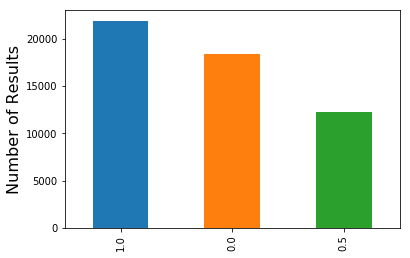

In [11]:
result_counts = df["Result"].value_counts()
print(result_counts)
result_counts.plot.bar()
plt.ylabel("Number of Results", fontsize=16)

From this initial exploration, we can see that white wins are the most prevalent among the dataset, but there is still a pretty good value of black wins and draws.  I also have not processed the whole dataset yet since there was so much to process, so as I get more in depth I should fully process and maybe process more data.

### Data Modeling and Prediction

As a first pass, I'm going to try to model with linear regression, hopefully ending up with a model that returns a number between 0 and 1 to represent the probability that white or black will win the game.

In [12]:
df_train, df_test = train_test_split(df)
print(df.shape[0], df_train.shape[0], df_test.shape[0])

52500 39375 13125


In [13]:
y_train = df_train["Result"].values
y_test = df_test["Result"].values

In [14]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)
null_lr = SGDRegressor(max_iter=2000)
null_lr.fit(zeros_train, y_train)
pred_result_null_test = null_lr.predict(zeros_test)
null_mse = mean_squared_error(y_test, pred_result_null_test)
null_rmse = np.sqrt(null_mse)

print("Null Model MSE:", null_mse)
print("Null Model RMSE:", null_rmse)

Null Model MSE: 0.18934776053796748
Null Model RMSE: 0.43514108118858125


In [15]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [18]:
all_columns = numerical_columns + categorical_columns

X_train, X_test = create_feature_matrices(df_train, df_test, all_columns, dummy_columns)

all_lr = SGDRegressor(max_iter=2000)
all_lr.fit(X_train, y_train)
pred_result_all_test = all_lr.predict(X_test)
all_mse = mean_squared_error(y_test, pred_result_all_test)
all_rmse = np.sqrt(all_mse)

print("Base Model MSE:", null_mse)
print("Base Model RMSE:", null_rmse)
print()
print("All Columns Model MSE:", all_mse)
print("All Columns Model RMSE:", all_rmse)

Base Model MSE: 0.18934776053796748
Base Model RMSE: 0.43514108118858125

All Columns Model MSE: 0.1410006422782758
All Columns Model RMSE: 0.37550052234088277


(0, 1.1)

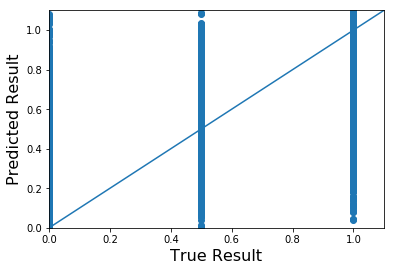

In [19]:
plt.scatter(y_test, pred_result_all_test)
m = max(max(y_test), max(pred_result_all_test))
plt.plot([0, m], [0, m])
plt.xlabel("True Result", fontsize=16)
plt.ylabel("Predicted Result", fontsize=16)
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])

The results for linear regression are not the best, so I'm going to try logistic regression to determine if this method will produce better results.

In [21]:
df_train, df_test = train_test_split(df, stratify=df["Result"])
print(df.shape[0], df_train.shape[0], df_test.shape[0])

52500 39375 13125


In [22]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["Result"].astype("str"))
y_test = encoder.transform(df_test["Result"].astype("str"))
print(y_train)

[1 0 0 ... 1 2 2]


In [24]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)

null_lr = SGDClassifier(max_iter=2000, loss="log")
null_lr.fit(zeros_train, y_train)
pred_null_results = null_lr.predict(zeros_test)
pred_prob = null_lr.predict_proba(zeros_test)

null_accuracy = accuracy_score(y_test, pred_null_results)
null_loss = log_loss(y_test, pred_prob)
cm = confusion_matrix(y_test, pred_null_results)

print("Accuracy:", null_accuracy)
print("Loss:", null_loss)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)

Accuracy: 0.4169904761904762
Loss: 1.071463252489124
Labels: ['0.0' '0.5' '1.0']
Confusion matrix:
[[   0    0 4598]
 [   0    0 3054]
 [   0    0 5473]]


In [25]:
X_train, X_test = create_feature_matrices(df_train, df_test, all_columns, dummy_columns)
    
lr = SGDClassifier(max_iter=2000, loss="log")
lr.fit(X_train, y_train)
pred_results = lr.predict(X_test)
pred_prob = lr.predict_proba(X_test)

accuracy = accuracy_score(y_test, pred_results)
loss = log_loss(y_test, pred_prob)
cm = confusion_matrix(y_test, pred_results)

print()
print("Model Accuracy:", accuracy)
print("Loss:", loss)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)


Model Accuracy: 0.6233904761904762
Loss: 0.8183952839999641
Labels: ['0.0' '0.5' '1.0']
Confusion matrix:
[[2956  348 1294]
 [ 678 1325 1051]
 [1130  442 3901]]


### Results Analysis